<a href="https://colab.research.google.com/github/HarryPotter12/PractiseML/blob/master/Amazon_Hackathon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Problem Statement
We all know that when we visit an e-commerce or TV series website or even YouTube we see a separate suggestion box, where in they show some content which you might like. These are mainly based on the content that you have consumed on their website previously. These are called as Recommendation engine. 

Now consider you have been running a start up since last one year and now you have been able to gather some customer data and you want to build a recommendation engine. Based on certain features you have to cluster the customers into two different groups so that you can recommend the correct products based on the customer’s cluster.

#### Challenge
1. Your work is to build a predictive model to predict the category of the customer. You have to predict the column : “customer_category”
2. You need to upload a presentation proposal addressing the following questions:
 * What are the pros & cons of recommendation by this approach?
 * Propose an architecture that will work more efficiently when building a recommendation engine for an e-commerce platform

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, precision_score, make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

In [ ]:
df_train = pd.read_csv("/content/gdrive/My Drive/Datasets/Amazon/train.csv")
df_test = pd.read_csv("/content/gdrive/My Drive/Datasets/Amazon/test.csv")

In [ ]:
df_train.head()

,customer_id,customer_visit_score,customer_product_search_score,customer_ctr_score,customer_stay_score,customer_frequency_score,customer_product_variation_score,customer_order_score,customer_affinity_score,customer_active_segment,X1,customer_category
0,csid_1,13.168425,9.447662,-0.070203,-0.139541,0.436956,4.705761,2.537985,7.959503,C,F,0
1,csid_2,17.092979,7.329056,0.153298,-0.102726,0.380340,4.205138,4.193444,17.517381,C,A,0
2,csid_3,17.505334,5.143676,0.106709,0.262834,0.417648,4.479070,3.878971,12.595155,C,BA,0
3,csid_4,31.423381,4.917740,-0.020226,-0.100526,0.778130,5.055535,2.708940,4.795073,AA,F,0
4,csid_5,11.909502,4.237073,0.187178,0.172891,0.162067,3.445247,3.677360,56.636326,C,AA,0


In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10738 entries, 0 to 10737
Data columns (total 12 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   customer_id                       10738 non-null  object 
 1   customer_visit_score              10738 non-null  float64
 2   customer_product_search_score     10696 non-null  float64
 3   customer_ctr_score                10738 non-null  float64
 4   customer_stay_score               10701 non-null  float64
 5   customer_frequency_score          10738 non-null  float64
 6   customer_product_variation_score  10692 non-null  float64
 7   customer_order_score              10672 non-null  float64
 8   customer_affinity_score           10738 non-null  float64
 9   customer_active_segment           10715 non-null  object 
 10  X1                                10701 non-null  object 
 11  customer_category                 10738 non-null  int64  
dtypes: f

In [ ]:
def preprocess(df):
  df['customer_product_search_score'].fillna(df['customer_product_search_score'].mean(), inplace=True)
  df['customer_stay_score'].fillna(df['customer_stay_score'].mean(), inplace=True)
  df['customer_product_variation_score'].fillna(df['customer_product_variation_score'].mean(), inplace=True)
  df['customer_order_score'].fillna(df['customer_order_score'].mean(), inplace=True)
  # df.drop(labels=['customer_order_score'], axis=1, inplace=True)
  # df.drop(labels=['customer_affinity_score'], axis=1, inplace=True)
  # df.drop(labels=['customer_active_segment'], axis=1, inplace=True)
  # df.drop(labels=['customer_frequency_score'], axis=1, inplace=True)
  df['X1'].fillna(df['X1'].mode()[0], inplace=True)
  df['customer_active_segment'].fillna(df['customer_active_segment'].mode()[0], inplace=True)
  replace_map = {'customer_active_segment': {'AA': 5, 'A': 4, 'B': 3, 'C': 2, 'D': 1},
                'X1': {'AA': 5, 'A': 4, 'BA': 3, 'E': 2, 'F': 1}}
  df.replace(replace_map, inplace=True)
  df['X1'] = df['X1'].astype('category')
  df['customer_active_segment'] = df['customer_active_segment'].astype('category')
  return df

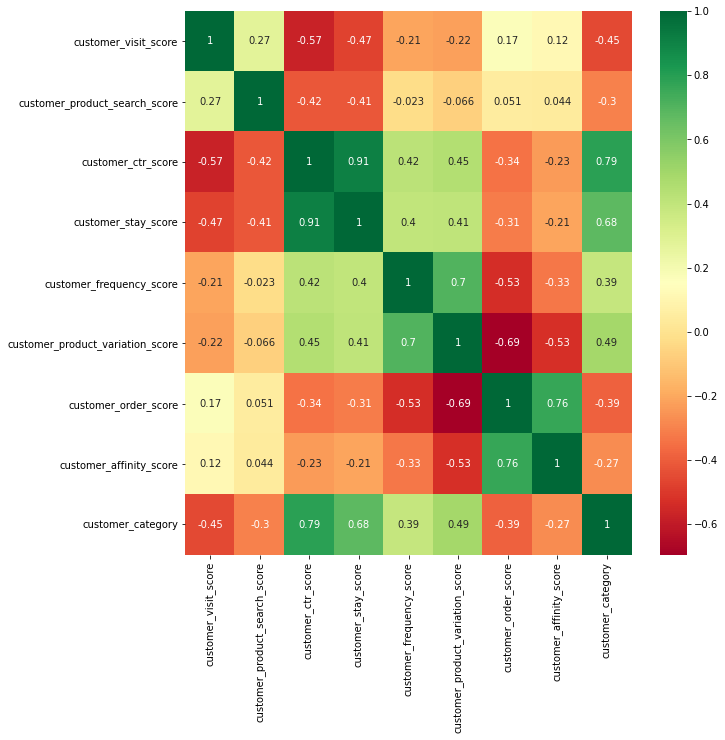

In [ ]:
corrmat = df_train.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(10,10))
g=sns.heatmap(df_train[top_corr_features].corr(),annot=True,cmap="RdYlGn")

In [ ]:
df_train = preprocess(df_train)

In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10738 entries, 0 to 10737
Data columns (total 12 columns):
 #   Column                            Non-Null Count  Dtype   
---  ------                            --------------  -----   
 0   customer_id                       10738 non-null  object  
 1   customer_visit_score              10738 non-null  float64 
 2   customer_product_search_score     10738 non-null  float64 
 3   customer_ctr_score                10738 non-null  float64 
 4   customer_stay_score               10738 non-null  float64 
 5   customer_frequency_score          10738 non-null  float64 
 6   customer_product_variation_score  10738 non-null  float64 
 7   customer_order_score              10738 non-null  float64 
 8   customer_affinity_score           10738 non-null  float64 
 9   customer_active_segment           10738 non-null  category
 10  X1                                10738 non-null  category
 11  customer_category                 10738 non-null  int6

In [ ]:
missing_frac = df_train.isnull().mean()
print(sorted(missing_frac[missing_frac > 0].index))

[]


In [ ]:
X_train_full = df_train.loc[:, ~df_train.columns.isin(['customer_category','customer_id'])].values
y_train_full = df_train.loc[:, df_train.columns == 'customer_category'].values

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size = 0.25, random_state = 42, stratify = y_train_full)

In [ ]:
df_test = preprocess(df_test)

In [ ]:
X_test = df_test.loc[:, ~df_test.columns.isin(['customer_category','customer_id'])].values

In [ ]:
f1 = make_scorer(precision_score, average='macro')

Let's create a Baseline Model based on Gradient Boosting Classifier first. We'll choose the 'learning_rate' from this.

In [ ]:
param_test0 = {'learning_rate':[0.15,0.1,0.05,0.01,0.005,0.001], 'n_estimators':range(100,2100,100)}
gsearch0 = GridSearchCV(estimator =GradientBoostingClassifier(max_depth=4, min_samples_split=2, min_samples_leaf=1, subsample=1, max_features='sqrt', random_state=42), 
            param_grid = param_test0, scoring=f1, n_jobs=40, cv=5)
gsearch0.fit(X_train,y_train.ravel())
gsearch0.best_params_, gsearch0.best_score_

({'learning_rate': 0.001, 'n_estimators': 800}, 0.9719847005830944)

In [ ]:
predictions = gsearch0.predict(X_val)
print("Model 0 : Classification Report of Validation Set")
print(classification_report(y_val, predictions))
print("Precision Score :",precision_score(y_val, predictions, average='macro'))

Model 0 : Classification Report of Validation Set
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      2361
           1       0.98      0.75      0.85       324

    accuracy                           0.97      2685
   macro avg       0.97      0.87      0.92      2685
weighted avg       0.97      0.97      0.97      2685

Precision Score : 0.9733005612400227


Now let's tune the parameter 'n_estimators' (number of trees) setting the 'learning_rate' = 0.001

In [ ]:
param_test1 = {'n_estimators':range(300,1001,50)}
gsearch1 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.001, max_depth=4, min_samples_split=2, min_samples_leaf=1, subsample=1, max_features='sqrt', random_state=42), 
                        param_grid = param_test1, scoring=f1, n_jobs=40, cv=5)
gsearch1.fit(X_train,y_train.ravel())
gsearch1.best_params_, gsearch1.best_score_

({'n_estimators': 800}, 0.9719847005830944)

In [ ]:
predictions = gsearch1.predict(X_val)
print("Model 1 : Classification Report of Validation Set")
print(classification_report(y_val, predictions))
print("Precision Score :",precision_score(y_val, predictions, average='macro'))

Model 1 : Classification Report of Validation Set
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      2361
           1       0.98      0.75      0.85       324

    accuracy                           0.97      2685
   macro avg       0.97      0.87      0.92      2685
weighted avg       0.97      0.97      0.97      2685

Precision Score : 0.9733005612400227


We found the best 'n_estimators' = 800. \
Now let's start Tuning tree-specific parameters.
1. max_depth and num_samples_split
2. min_samples_leaf
3. max_features

In [ ]:
param_test2 = {'max_depth':range(1,8,2), 'min_samples_split':range(100,501,100)}
gsearch2 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.001, n_estimators=800, min_samples_leaf=1, subsample=1, max_features='sqrt', random_state=42), 
                        param_grid = param_test2, scoring=f1, n_jobs=20, cv=5)
gsearch2.fit(X_train,y_train.ravel())
gsearch2.best_params_, gsearch2.best_score_

({'max_depth': 5, 'min_samples_split': 200}, 0.9723284703047458)

In [ ]:
predictions = gsearch2.predict(X_val)
print("Model 2 : Classification Report of Validation Set")
print(classification_report(y_val, predictions))
print("Precision Score :",precision_score(y_val, predictions, average='macro'))

Model 2 : Classification Report of Validation Set
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      2361
           1       0.98      0.74      0.85       324

    accuracy                           0.97      2685
   macro avg       0.97      0.87      0.91      2685
weighted avg       0.97      0.97      0.97      2685

Precision Score : 0.9748285379725661


We found 'max_depth' = 5, 'min_samples_split' = 200 as the best. \
Let's tune 'min_samples_leaf'.

In [ ]:
param_test3 = {'min_samples_leaf':range(30,101,10)}
gsearch3 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.001, n_estimators=800, max_depth=5, min_samples_split=200, subsample=1, max_features='sqrt', random_state=42), 
                        param_grid = param_test3, scoring=f1, n_jobs=40, cv=5)
gsearch3.fit(X_train, y_train.ravel())
gsearch3.best_params_, gsearch3.best_score_

({'min_samples_leaf': 70}, 0.9724269310869433)

In [ ]:
predictions = gsearch3.predict(X_val)
print("Model 3 : Classification Report of Validation Set")
print(classification_report(y_val, predictions))
print("Precision Score :",precision_score(y_val, predictions, average='macro'))

Model 3 : Classification Report of Validation Set
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      2361
           1       0.98      0.73      0.84       324

    accuracy                           0.97      2685
   macro avg       0.97      0.86      0.91      2685
weighted avg       0.97      0.97      0.96      2685

Precision Score : 0.9739025541422469


Setting the best 'min_samples_leaf' = 70, let's tune 'max_features'.

In [ ]:
param_test4 = {'max_features':range(7,20,2)}
gsearch4 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.001, n_estimators=800, max_depth=5, min_samples_split=200, min_samples_leaf=70, subsample=1, random_state=42),
                        param_grid = param_test4, scoring=f1, n_jobs=5, cv=5)
gsearch4.fit(X_train, y_train.ravel())
gsearch4.best_params_, gsearch4.best_score_

({'max_features': 9}, 0.9708170532834286)

In [ ]:
predictions = gsearch4.predict(X_val)
print("Model 4 : Classification Report of Validation Set")
print(classification_report(y_val, predictions))
print("Precision Score :",precision_score(y_val, predictions, average='macro'))

Model 4 : Classification Report of Validation Set
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      2361
           1       0.98      0.79      0.87       324

    accuracy                           0.97      2685
   macro avg       0.97      0.89      0.93      2685
weighted avg       0.97      0.97      0.97      2685

Precision Score : 0.9745174268224679


Finally we'll tune the parameter 'subsample'.

In [ ]:
param_test5 = {'subsample':[0.6,0.7,0.75,0.8,0.85,0.9]}
gsearch5 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.001, n_estimators=800, max_depth=5, min_samples_split=200, min_samples_leaf=70, max_features=9, random_state=42),
                        param_grid = param_test5, scoring=f1, n_jobs=5, cv=5)
gsearch5.fit(X_train, y_train.ravel())
gsearch5.best_params_, gsearch5.best_score_

({'subsample': 0.9}, 0.9719751494548919)

In [ ]:
predictions = gsearch5.predict(X_val)
print("Model 5 : Classification Report of Validation Set")
print(classification_report(y_val, predictions))
print("Precision Score :",precision_score(y_val, predictions, average='macro'))

Model 5 : Classification Report of Validation Set
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      2361
           1       0.98      0.78      0.87       324

    accuracy                           0.97      2685
   macro avg       0.98      0.89      0.93      2685
weighted avg       0.97      0.97      0.97      2685

Precision Score : 0.9759204499517773


Now, as we have our best hyper-parameters, let's build our final model. The hyper-parameters are as follows:
* learning_rate=0.001
* n_estimators=800
* max_depth=5
* min_samples_split=200
* min_samples_leaf=70
* max_features=9
* subsample=0.9

In [ ]:
gb = GradientBoostingClassifier(learning_rate=0.001, n_estimators=800, max_depth=5, min_samples_split=200, min_samples_leaf=70, max_features=9, subsample=0.9, random_state=42)
gb.fit(X_train, y_train.ravel())

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.001, loss='deviance', max_depth=5,
                           max_features=9, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=70, min_samples_split=200,
                           min_weight_fraction_leaf=0.0, n_estimators=800,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=42, subsample=0.9, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [ ]:
# gb = GradientBoostingClassifier(learning_rate=0.001, n_estimators=800, max_depth=5, min_samples_split=200, min_samples_leaf=70, max_features=8, subsample=0.9, random_state=42)
# gb.fit(X_train, y_train.ravel())

In [ ]:
# gb = GradientBoostingClassifier(learning_rate=0.001, n_estimators=800, max_depth=5, min_samples_split=200, min_samples_leaf=70, max_features=9, subsample=0.9, random_state=42)
# gb.fit(X_train, y_train.ravel())

In [ ]:
y_val_pred = gb.predict(X_val)
print("Final Model : Confusion Matrix of Test Set")
print(confusion_matrix(y_val, y_val_pred))
print()
print("Final Model : Classification Report of Validation Set")
print(classification_report(y_val, y_val_pred))
print("Precision Score :",precision_score(y_val, y_val_pred, average='macro'))

Final Model : Confusion Matrix of Test Set
[[2356    5]
 [  70  254]]

Final Model : Classification Report of Validation Set
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      2361
           1       0.98      0.78      0.87       324

    accuracy                           0.97      2685
   macro avg       0.98      0.89      0.93      2685
weighted avg       0.97      0.97      0.97      2685

Precision Score : 0.9759204499517773


We'll now re-fit the final model with complete training set (including the validation set) and predict using the test set.

In [ ]:
gb = GradientBoostingClassifier(learning_rate=0.001, n_estimators=800, max_depth=5, min_samples_split=200, min_samples_leaf=70, max_features=9, subsample=0.9, random_state=42)
gb.fit(X_train_full, y_train_full.ravel())

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.001, loss='deviance', max_depth=5,
                           max_features=9, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=70, min_samples_split=200,
                           min_weight_fraction_leaf=0.0, n_estimators=800,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=42, subsample=0.9, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [ ]:
y_pred = gb.predict(X_test)

In [ ]:
output = pd.DataFrame(data={"customer_id": df_test["customer_id"], "customer_category": y_pred})
output.to_csv(path_or_buf="/content/gdrive/My Drive/Amazon-result.csv", index=False)

[1.00912539e-04 1.20177852e-03 8.92689119e-01 8.47310429e-02
 2.34490548e-03 5.91845678e-03 2.32789597e-03 1.06810656e-02
 2.69007428e-06 2.13268935e-06]


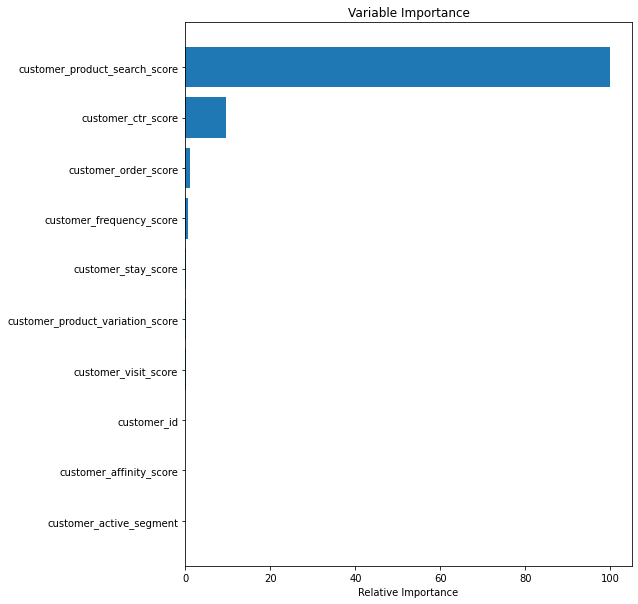

In [ ]:
feature_importance = gb.feature_importances_
print(feature_importance)
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.figure(figsize=(8, 10))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, df_train.keys()[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()